In [138]:
import pandas as pd
from datasets import Dataset
from transformers import ElectraConfig, ElectraTokenizer, ElectraForSequenceClassification, Trainer, TrainingArguments, TrainerCallback, logging
import torch
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import random

seed_value = 1999

random.seed(seed_value)
torch.manual_seed(seed_value)
np.random.seed(seed_value)

In [139]:
# Percorsi dei file CSV
train_csv_path = "https://raw.githubusercontent.com/alesmk/HLT/main/data/New%20dataset/BERT/train_tweets_Transformers_new_binary.csv"
eval_csv_path = "https://raw.githubusercontent.com/alesmk/HLT/main/data/New%20dataset/BERT/eval_tweets_Transformers_new_binary.csv"
test_csv_path = "https://raw.githubusercontent.com/alesmk/HLT/main/data/New%20dataset/BERT/test_tweets_Transformers_new_binary.csv"

In [140]:
from datasets import load_dataset, Dataset, DatasetDict, Features, Value
# Caricamento dei dataset
train_df = pd.read_csv(train_csv_path)
eval_df = pd.read_csv(eval_csv_path)
test_df = pd.read_csv(test_csv_path)


train_df = train_df.sample(frac=1).reset_index(drop=True)
eval_df = eval_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)


dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(train_df)
dataset['test'] = Dataset.from_pandas(test_df)
dataset['validation'] = Dataset.from_pandas(eval_df)
dataset.shape

{'train': (9904, 2), 'test': (2674, 2), 'validation': (2490, 2)}

In [141]:
# Preprocessing
tokenizer = ElectraTokenizer.from_pretrained("google/electra-small-discriminator")

In [142]:
from sklearn.preprocessing import LabelEncoder
possible_labels = train_df.cyberbullying_type.unique()

le = LabelEncoder()
label_dict = le.fit_transform(possible_labels)

In [143]:
def preprocess_function(examples):
    encoded_example=tokenizer(examples["tweet_text"], padding="max_length", truncation=True, max_length=70, return_tensors="pt")
    encoded_example["label"] = label_dict[le.transform(examples["cyberbullying_type"])]
    return encoded_example

In [144]:
encoded_dataset = dataset.map(preprocess_function, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/9904 [00:00<?, ? examples/s]

Map:   0%|          | 0/2674 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

In [145]:
# Convertire i dataset in tensori PyTorch
encoded_dataset.set_format("torch")

In [146]:
# Preparazione del modello

# Crea una configurazione personalizzata con dropout
config = ElectraConfig.from_pretrained(
    'google/electra-small-discriminator',
    hidden_dropout_prob=0.3,  # Imposta il tasso di dropout
    attention_probs_dropout_prob=0.5,  # Imposta il tasso di dropout per l'attenzione
    num_labels=5
)

# Crea il modello con la configurazione personalizzata
model = ElectraForSequenceClassification.from_pretrained(
    'google/electra-small-discriminator',
    config=config
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [147]:
# Definizione dei parametri di addestramento
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    logging_steps=100,
    load_best_model_at_end=True,  # Carica il miglior modello alla fine
    metric_for_best_model="eval_loss",  # Metric per il miglior modello
)

early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [148]:
class ComputeMetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_accuracies = []
        self.eval_accuracies = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Calcolare l'accuratezza sul set di addestramento
        train_predictions = trainer.predict(trainer.train_dataset)
        train_accuracy = accuracy_score(train_predictions.label_ids, np.argmax(train_predictions.predictions, axis=1))
        self.train_accuracies.append(train_accuracy)

        # Calcolare l'accuratezza sul set di validazione
        eval_predictions = trainer.predict(trainer.eval_dataset)
        eval_accuracy = accuracy_score(eval_predictions.label_ids, np.argmax(eval_predictions.predictions, axis=1))
        self.eval_accuracies.append(eval_accuracy)

        # Aggiorna i log solo se esiste un log precedente
        if state.log_history:
          state.log_history[-1]['train_accuracy'] = train_accuracy
          state.log_history[-1]['eval_accuracy'] = eval_accuracy
        else:
          state.log_history.append({'train_accuracy': train_accuracy, 'eval_accuracy': eval_accuracy})

# Funzione di valutazione personalizzata
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': acc,
        'f1': f1,
    }

In [149]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.5, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [150]:
#forward pass
outputs = model(input_ids=encoded_dataset['train']['input_ids'][0].unsqueeze(0).to(device), attention_mask=encoded_dataset['train']['attention_mask'][0].unsqueeze(0).to(device)
,labels=encoded_dataset['train'][0]['label'].unsqueeze(0).to(device))

In [151]:
mycallback = ComputeMetricsCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[mycallback, early_stopping_callback]
)

In [152]:
# Addestramento del modello
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.337000,0.561812,0.837751,0.835378
2,0.284700,0.556651,0.847390,0.845641
3,0.253800,0.415944,0.873092,0.872418
4,0.243500,0.334699,0.892369,0.892062
5,0.209300,0.325987,0.898795,0.898548
6,0.207700,0.290211,0.905622,0.905464
7,0.199100,0.268900,0.917671,0.917623
8,0.192200,0.317233,0.906827,0.906655
9,0.174000,0.291613,0.914859,0.914786


TrainOutput(global_step=2790, training_loss=0.2580824055552055, metrics={'train_runtime': 220.463, 'train_samples_per_second': 449.236, 'train_steps_per_second': 14.061, 'total_flos': 358553155746240.0, 'train_loss': 0.2580824055552055, 'epoch': 9.0})

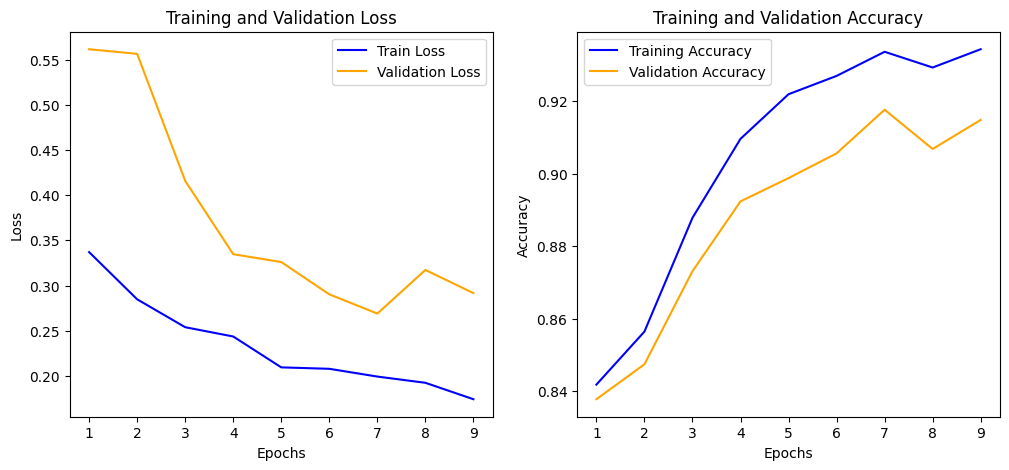

In [157]:
import matplotlib.pyplot as plt

# Recupera i log dell'addestramento
history = trainer.state.log_history

# Estrai i valori di perdita e accuratezza
train_loss = [log['loss'] for log in history if 'loss' in log]
train_loss = [train_loss[i] for i in range(2, len(train_loss), 3)]
eval_loss = [log['eval_loss'] for log in history if 'eval_loss' in log]
train_accuracy = mycallback.train_accuracies
eval_accuracy = mycallback.eval_accuracies

# Crea i grafici

plt.figure(figsize=(12, 5))

# Grafico della perdita
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', color='blue')
plt.plot(range(1, len(eval_loss)+1), eval_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Grafico dell'accuratezza
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy', color='blue')
plt.plot(range(1, len(eval_accuracy) + 1), eval_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()

In [158]:
trainer.save_model("./ELECTRA_binary_finetuned")

In [159]:
# Valutazione finale sul dataset di test
test_results = trainer.evaluate(encoded_dataset["test"])
print("Test results:", test_results)

Test results: {'eval_loss': 0.2871268689632416, 'eval_accuracy': 0.9113687359760658, 'eval_f1': 0.9113147216463579, 'eval_runtime': 1.3664, 'eval_samples_per_second': 1956.942, 'eval_steps_per_second': 61.475, 'epoch': 9.0}
